In [1]:
from SheepDogEnv import SheepDogEnv
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [7]:

def orthogonal_init(layer, gain=1.0):
    nn.init.orthogonal_(layer.weight, gain=gain)
    nn.init.constant_(layer.bias, 0)


class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, use_orthogonal_init=False):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        if use_orthogonal_init:
            print("------use_orthogonal_init------")
            orthogonal_init(self.fc1)
            orthogonal_init(self.fc2)
            orthogonal_init(self.fc_mu, gain=0.01)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # print(self.fc_mu(x))
        mu = np.pi / 2 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, use_orthogonal_init=False):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)
        if use_orthogonal_init:
            print("------use_orthogonal_init------")
            orthogonal_init(self.fc1)
            orthogonal_init(self.fc2)
            orthogonal_init(self.fc3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device, use_orthogonal_init=False):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim, use_orthogonal_init).to(device)
        self.critic = ValueNet(state_dim, hidden_dim,
                               use_orthogonal_init).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state, otp=False):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        if otp:
            print(mu, sigma)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards) / 4.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        # print("td_target:", td_target, self.critic(states))
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [8]:
actor_lr = 1e-5
critic_lr = 5e-4
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


env = SheepDogEnv(circle_R=350, sheep_v=70, dog_v=80,
                  sec_split_n=10, store_mode=True, render_mode=False)
torch.manual_seed(0)
state_dim = env._get_obs_array().shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间

In [9]:
transition_dict = {
    'states': [],
    'actions': [],
    'next_states': [],
    'rewards': [],
    'dones': []
}
agent = PPOContinuous(state_dim, hidden_dim, action_dim,
                      actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device,
                      use_orthogonal_init=True)
env.reset()
for i in range(1000):
    _st = env._get_obs_array()
    act = agent.take_action(state=_st)[0]
    st, reward, done, _, _ = env.step(action=act)
    transition_dict["states"].append(_st)
    transition_dict["actions"].append(act)
    transition_dict["next_states"].append(st)
    transition_dict["rewards"].append(reward)
    transition_dict["dones"].append(done)
    print(i, _st, act, reward, st)
    if done:
        break

agent.update(transition_dict=transition_dict)

------use_orthogonal_init------
------use_orthogonal_init------
0 [ 7.          1.90212771  5.86216097 -2.32315205] -0.6608513593673706 6.3851113775346455 [13.24266047  2.23255339  5.88501811 -2.63072059]
1 [13.24266047  2.23255339  5.88501811 -2.63072059] 0.11914443224668503 6.731460133249301 [20.21016984  2.19137242  5.90787525 -2.56668247]
2 [20.21016984  2.19137242  5.90787525 -2.56668247] 1.6061344146728516 0.008650824393308887 [21.15311805  1.8543125   5.9307324  -2.20676541]
3 [21.15311805  1.8543125   5.9307324  -2.20676541] 0.22038975358009338 5.619265425098869 [28.02561379  1.79968279  5.95358954 -2.12927856]
4 [28.02561379  1.79968279  5.95358954 -2.12927856] -0.21411924064159393 6.141387738467486 [34.89747398  1.84231793  5.97644668 -2.14905655]
5 [34.89747398  1.84231793  5.97644668 -2.14905655] 0.1340092569589615 5.6310685484296785 [41.84516636  1.81996559  5.99930382 -2.10384707]
6 [41.84516636  1.81996559  5.99930382 -2.10384707] -0.47213056683540344 6.032810494420148 [

In [10]:
def test_agent(env,agent):
    test_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': []
    }
    catched_num=0
    for ii in range(10):
        for i in range(1000):
            _st = env._get_obs_array()
            _st[0]/=env.circle_R
            _st[1]=(_st[2]-np.pi)/np.pi
            _st[2]=(_st[2]-np.pi)/np.pi
            act = agent.take_action(state=_st)[0]
            st, reward, done, _, _ = env.step(action=act)
            test_dict["states"].append(_st)
            test_dict["actions"].append(act)
            test_dict["next_states"].append(st)
            test_dict["rewards"].append(reward)
            test_dict["dones"].append(done)
            # print(i, _st, act, reward, st)
            # print(reward)
            if done:
                if reward<-900:
                    catched_num+=1
                break
        env.reset()
    print("test:",len(test_dict["rewards"]) ,np.mean(test_dict['rewards']),"be catched: 10/{}".format(catched_num))
    return np.mean(test_dict["rewards"])
test_agent(env=env,agent=agent)

test: 538 -6.435753868106147 be catched: 10/5


-6.435753868106147

------use_orthogonal_init------
------use_orthogonal_init------
0
test: 249 14.63211608473937 be catched: 10/1
50
test: 253 -12.248378797146533 be catched: 10/5
100
test: 259 9.336241861635907 be catched: 10/2
150
test: 261 27.06036743032606 be catched: 10/0
200
test: 259 -20.027362068170245 be catched: 10/6
250
test: 255 2.6562048063403165 be catched: 10/3
300
test: 249 0.21523338888339158 be catched: 10/3
350
test: 242 -13.842753366558496 be catched: 10/5
400
test: 248 11.350910094648459 be catched: 10/2
450
test: 251 -15.516451904901661 be catched: 10/5
500
test: 250 4.386487587465094 be catched: 10/3
550
test: 247 -2.8296208673775776 be catched: 10/4
600
test: 244 0.9647551239950917 be catched: 10/3
650
test: 261 11.445445245122409 be catched: 10/2
700
test: 255 17.03489758822248 be catched: 10/1
750
test: 241 11.317054303224038 be catched: 10/2
800
test: 247 -7.676430277548676 be catched: 10/4
850
test: 255 -10.190845168695176 be catched: 10/5
900
test: 251 14.147194943305273 be c

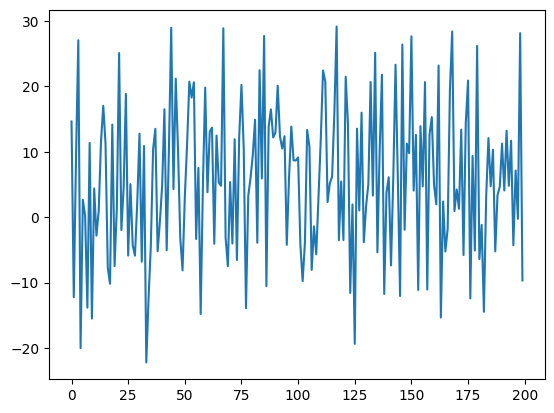

In [132]:
actor_lr = 7e-6
critic_lr = 1e-4
num_episodes = 2000
hidden_dim = 128
gamma = 0.5
lmbda = 0.9
epochs = 5
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

agent = PPOContinuous(state_dim, hidden_dim, action_dim,
                      actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device,
                      use_orthogonal_init=True)

env = SheepDogEnv(circle_R=350, sheep_v=80, dog_v=80,
                  sec_split_n=5, store_mode=True, render_mode=False)
r_list=[]

for ii in range(10000):
    transition_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': []
    }
    for i in range(1000):
        _st = env._get_obs_array()

        L1 = _st[0]
        L2 = env.circle_R
        theta1 = _st[1]
        theta2 = _st[2]
        L3 = np.sqrt(L1**2 + L2**2 - 2*L1*L2*np.cos(theta2-theta1))
        theta3 = np.arcsin(L2/L3*np.sin(theta2-theta1))
        if(np.abs(theta2-theta1) < np.arccos(L1/L2)):
            theta3 = np.pi/2 if theta3 >= 0 else -np.pi/2
        
        _st[0]/=env.circle_R
        # _st[1]=(_st[1]-np.pi)/np.pi
        # _st[2]=(_st[2]-np.pi)/np.pi
        act = agent.take_action(state=_st)[0] if np.random.random()>(0.4)*(1-i/10000) else theta3

        st, reward, done, _, _ = env.step(action=act)
        st[0]/=env.circle_R
        # st[1]=(st[1]-np.pi)/np.pi
        # st[2]=(st[2]-np.pi)/np.pi
        transition_dict["states"].append(_st)
        transition_dict["actions"].append(act)
        transition_dict["next_states"].append(st)
        transition_dict["rewards"].append(reward)
        transition_dict["dones"].append(done)
        # print(i, _st, act, reward, st)
        # print(reward)
        if done:
            break
    env.reset()
    if(i<2000):
        env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
        env.dog_theta=np.array([(env.sheep_polar_coor[1]-np.pi)%(np.pi*2)])
    elif(i<4000):
        env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
        env.dog_theta=np.array([env.sheep_polar_coor[1]])
    elif(i<7000):
        env.sheep_polar_coor=np.array([np.random.randint(env.sheep_v,env.circle_R-50),np.random.random()*np.pi*2])
    # elif(i<4000):
    #     env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
    #     env.dog_theta=np.array([(env.sheep_polar_coor[1]-np.pi)%(np.pi*2)])
    # elif(i<5000):
    #     env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
    #     env.dog_theta=np.array([env.sheep_polar_coor[1]])
    # elif(i<6000):
    #     env.sheep_polar_coor=np.array([np.random.randint(env.sheep_v,env.circle_R-50),np.random.random()*np.pi*2])
    # elif(i<7000):
    #     env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
    #     env.dog_theta=np.array([(env.sheep_polar_coor[1]-np.pi)%(np.pi*2)])
    # elif(i<8000):
    #     env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
    #     env.dog_theta=np.array([env.sheep_polar_coor[1]])
    # elif(i<9000):
    #     env.sheep_polar_coor=np.array([np.random.randint(env.sheep_v,env.circle_R-50),np.random.random()*np.pi*2])
    agent.update(transition_dict)
    if(ii % 50 == 0):
        print(ii)
        r_list.append(test_agent(env, agent))
plt.plot(r_list)

In [112]:
env.reset()
_st = env._get_obs_array()
_st[0]/=env.circle_R
# _st[2]=(_st[2]-np.pi)/np.pi
act = agent.take_action(state=_st)[0]
st, reward, done, _, info = env.step(action=act)
# print(_st)
print(act, reward)
# print(st)
print(info)
print("critic:_st_score:",agent.critic(torch.tensor(_st,dtype=torch.float).to(device)))
print("critic:st_score:",agent.critic(torch.tensor(st,dtype=torch.float).to(device)))
print("critic:st_score:",agent.critic(torch.tensor([0.2,0,0.3,0.3],dtype=torch.float).to(device)))

-0.776055097579956 4.276175585202766
{'distance': array([353.14461242])}
critic:_st_score: tensor([3.7420], device='cuda:0', grad_fn=<AddBackward0>)
critic:st_score: tensor([-1.1441], device='cuda:0', grad_fn=<AddBackward0>)
critic:st_score: tensor([15.8134], device='cuda:0', grad_fn=<AddBackward0>)


In [110]:

torch.save(agent.actor.state_dict(),"actor-4")
# torch.save(agent.critic.state_dict(),"critic-1")"

In [131]:

env = SheepDogEnv(circle_R=350, sheep_v=30, dog_v=80,
                  sec_split_n=10, store_mode=False, render_mode=False)

# env.reset()
env.sheep_polar_coor=np.array([env.sheep_v,np.random.random()*np.pi*2])
env.dog_theta=np.array([(env.sheep_polar_coor[1]-np.pi)%(np.pi*2)])
for i in range(2000):
    _st = env._get_obs_array()
    _st[0]/=env.circle_R
    _st[1]=(_st[1]-np.pi)/np.pi
    _st[2]=(_st[2]-np.pi)/np.pi
    action = agent.take_action(state=_st, otp=True)[0]
    observation, reward, done, _, info = env.step(action)  # 和环境交互
    print(_st, action, reward)
    if done:
        break

tensor([-0.3276], device='cuda:0', grad_fn=<MulBackward0>) tensor([1.5475], device='cuda:0', grad_fn=<SoftplusBackward0>)
[ 0.00857143  0.85596093 -0.14403907 -3.14159265] 1.935356855392456 0.4032782272187774
tensor([-0.2578], device='cuda:0', grad_fn=<MulBackward0>) tensor([1.3012], device='cuda:0', grad_fn=<SoftplusBackward0>)
[ 0.00972365  0.54793932 -0.13676341 -2.15105708] -0.21455302834510803 2.6758121405991213
tensor([-0.2660], device='cuda:0', grad_fn=<MulBackward0>) tensor([1.3171], device='cuda:0', grad_fn=<SoftplusBackward0>)
[ 0.01819033  0.57992766 -0.12948776 -2.22869425] -0.08088591694831848 2.6737848580752486
tensor([-0.2680], device='cuda:0', grad_fn=<MulBackward0>) tensor([1.3129], device='cuda:0', grad_fn=<SoftplusBackward0>)
[ 0.0267427   0.58817181 -0.1222121  -2.23173687] 0.2411925196647644 2.3915335760616516
tensor([-0.2628], device='cuda:0', grad_fn=<MulBackward0>) tensor([1.2862], device='cuda:0', grad_fn=<SoftplusBackward0>)
[ 0.03512574  0.56960792 -0.1149364